In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tarfile

# Specify the path to the tarball file
tarball_path = "/content/drive/MyDrive/Colab Notebooks/UTKFace (1).tar.gz"

# Extract the contents of the tarball
with tarfile.open(tarball_path, 'r:gz') as tar_ref:
    tar_ref.extractall("/content")

In [ ]:
import os
import shutil

# Chemin vers le dossier UTKFace
utkface_folder = "/content/UTKFace"

# Créer un dossier de sortie
output_folder = "/content/UTKFaceN"
os.makedirs(output_folder, exist_ok=True)

# Définir les âges pour lesquels vous voulez collecter des images
ages_to_collect = list(range(1, 101))

# Nombre d'images à collecter par âge
images_per_age = 45

# Parcourir tous les fichiers dans le dossier UTKFace
for filename in os.listdir(utkface_folder):
    # Extraire l'âge du nom de fichier
    age = int(filename.split('_')[0])

    # Vérifier si l'âge est dans la liste des âges à collecter
    if age in ages_to_collect:
        # Copier le fichier dans le dossier UTKFaceM
        source_path = os.path.join(utkface_folder, filename)
        destination_path = os.path.join(output_folder, filename)
        shutil.copyfile(source_path, destination_path)

        # Décrémenter le nombre d'images à collecter pour cet âge
        images_per_age -= 1

        # Vérifier si vous avez collecté suffisamment d'images pour cet âge
        if images_per_age == 0:
            ages_to_collect.remove(age)
            images_per_age = 40  # Réinitialiser le nombre d'images à collecter pour le prochain âge

        if not ages_to_collect:
            break


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Explorer la structure du jeu de données
data_path = "/content/UTKFaceN"
images = []
labels = []

for filename in os.listdir(data_path):
    if filename.endswith(".jpg"):
        # Les noms de fichiers dans UTKFace sont formatés comme "âge_genre_date_heure_minute_seconde.jpg"
        age = int(filename.split('_')[0])
        labels.append(age)
        img_path = os.path.join(data_path, filename)
        img = cv2.imread(img_path)
        # Vous pouvez ajouter d'autres prétraitements d'image ici selon vos besoins
        # Ajout de prétraitements pour réduire le bruit
        img = cv2.resize(img, (224, 224))  # Redimensionner les images
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir l'image en format RGB
        #img = cv2.GaussianBlur(img, (3, 3), 0)  # Appliquer un filtre de Gauss pour le lissage

        # Vous pouvez ajouter d'autres prétraitements d'image ici selon vos besoins
        images.append(img)

# Convertir les listes en tableaux NumPy
images = np.array(images)
labels = np.array(labels)

# 2. Diviser le jeu de données en ensembles d'entraînement, de validation et de test
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 3. Normaliser les images (mise à l'échelle des pixels entre 0 et 1)
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0




In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np

# Charger le modèle ResNet50 pré-entraîné (poids ImageNet)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-10]:
    layer.trainable = True


# Ajouter des couches personnalisées pour la prédiction de l'âge
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='linear')(x)  # Activation linéaire pour la prédiction de l'âge

# Créer le modèle complet
model = models.Model(inputs=base_model.input, outputs=output)

# Compiler le modèle
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Afficher un résumé du modèle
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

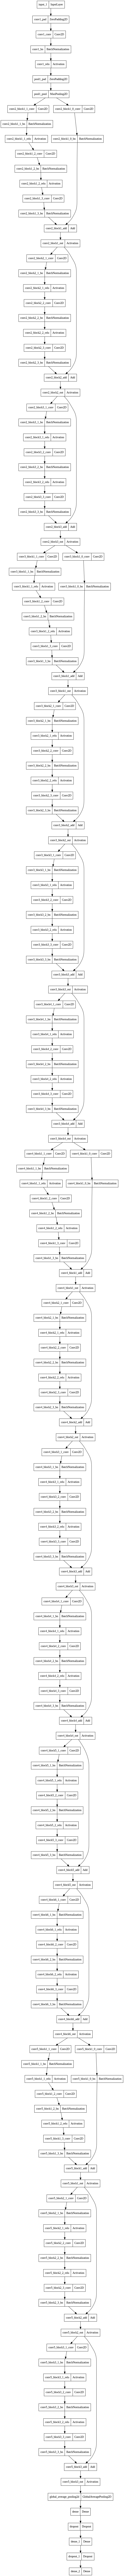

In [ ]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, validation_data=(X_val, y_val), epochs=70)

Epoch 1/70
72/72 [==============================] - 77s 426ms/step - loss: 746.0477 - mae: 20.5499 - val_loss: 1129.6428 - val_mae: 28.2441
Epoch 2/70
72/72 [==============================] - 25s 353ms/step - loss: 418.5941 - mae: 15.6112 - val_loss: 1203.5845 - val_mae: 27.5122
Epoch 3/70
72/72 [==============================] - 24s 333ms/step - loss: 324.9619 - mae: 13.5899 - val_loss: 2319.2905 - val_mae: 40.7212
Epoch 4/70
72/72 [==============================] - 24s 333ms/step - loss: 327.5579 - mae: 13.6331 - val_loss: 2219.7603 - val_mae: 39.5108
Epoch 5/70
72/72 [==============================] - 25s 354ms/step - loss: 305.3268 - mae: 13.1379 - val_loss: 1789.7397 - val_mae: 34.4595
Epoch 6/70
72/72 [==============================] - 25s 350ms/step - loss: 293.4047 - mae: 12.9289 - val_loss: 1696.8845 - val_mae: 33.3628
Epoch 7/70
72/72 [==============================] - 24s 334ms/step - loss: 265.5288 - mae: 12.1569 - val_loss: 1822.5337 - val_mae: 34.7323
Epoch 8/70
72/72 [==

In [ ]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

16/16 [==============================] - 2s 92ms/step - loss: 174.5402 - mae: 9.8087
Test Loss: 174.54022216796875, Test MAE: 9.808707237243652


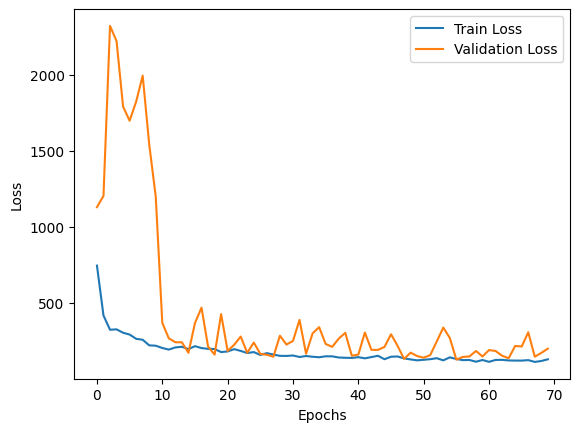

In [ ]:
import matplotlib.pyplot as plt

# Afficher les courbes d'apprentissage
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(X_test)
# Afficher les vrais âges et les prédictions sous forme de tableau
comparison_table = np.column_stack((y_test, predictions.flatten()))
print("Vrais Âges vs Prédictions d'Âge :\n", comparison_table)

16/16 [==============================] - 3s 95ms/step
Vrais Âges vs Prédictions d'Âge :
 [[ 34.          22.24396133]
 [ 52.          49.92613602]
 [ 58.          45.58759308]
 [ 27.          28.8026619 ]
 [ 40.          26.98794937]
 [ 13.           9.06828022]
 [ 64.          51.51537704]
 [ 72.          60.95429993]
 [ 31.          21.08222961]
 [ 84.          65.07866669]
 [ 60.          52.78307724]
 [ 52.          32.98615646]
 [  6.           6.65705109]
 [ 54.          42.54462814]
 [ 33.          36.33716202]
 [ 93.          61.14270782]
 [ 48.          59.12644196]
 [ 15.          19.37716293]
 [  7.           8.77554893]
 [ 25.          16.40270805]
 [  4.           9.06050873]
 [ 32.          25.00630188]
 [ 12.          16.19720078]
 [ 52.          36.08439636]
 [ 59.          37.94009781]
 [ 53.          49.99523544]
 [ 21.           6.65898514]
 [ 44.          22.81984329]
 [ 74.          63.795784  ]
 [ 92.          72.72840881]
 [ 19.          17.55541229]
 [ 60.      

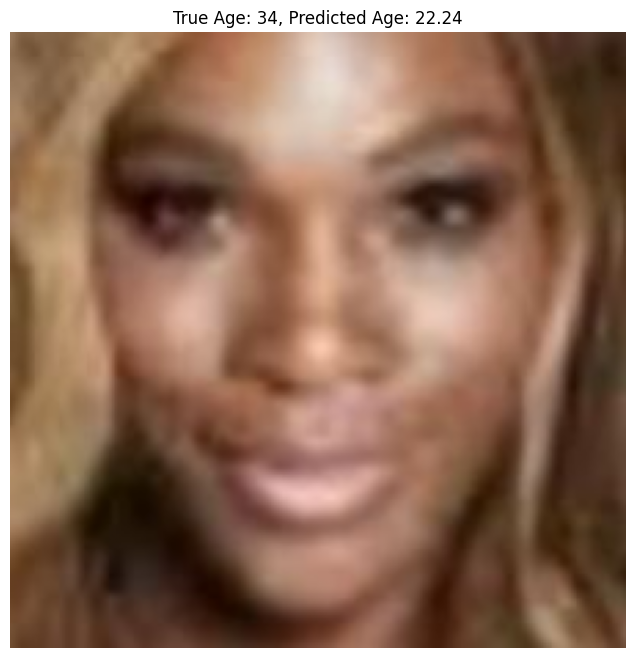

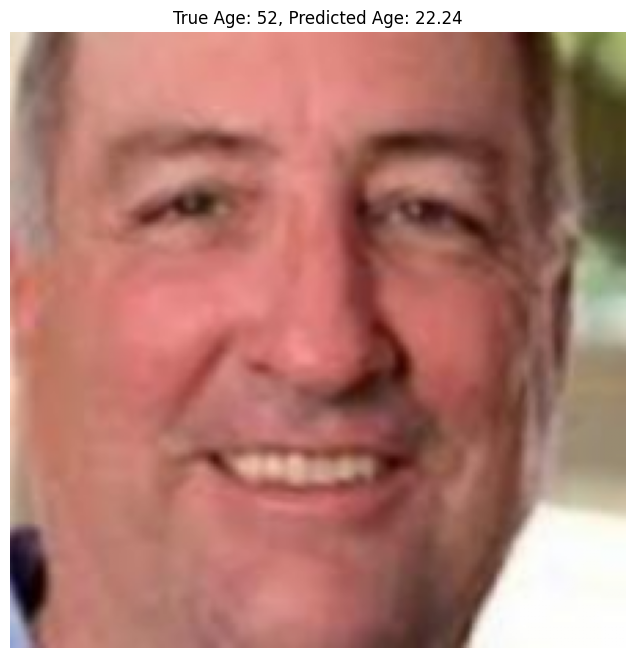

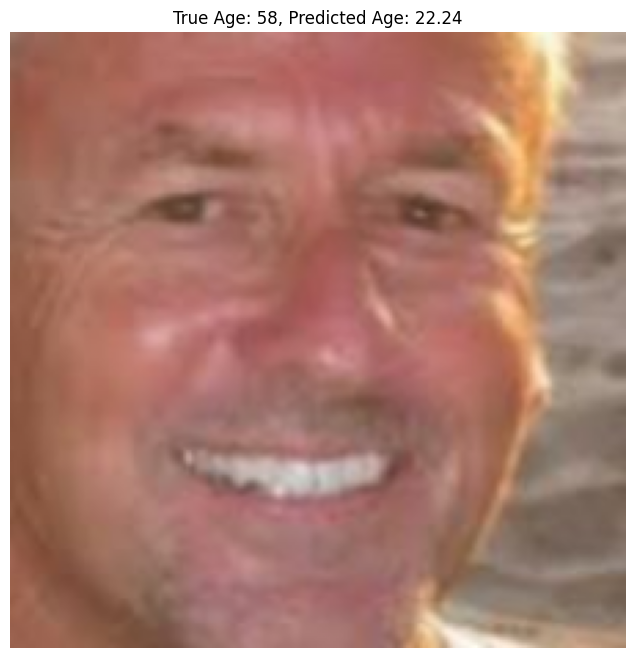

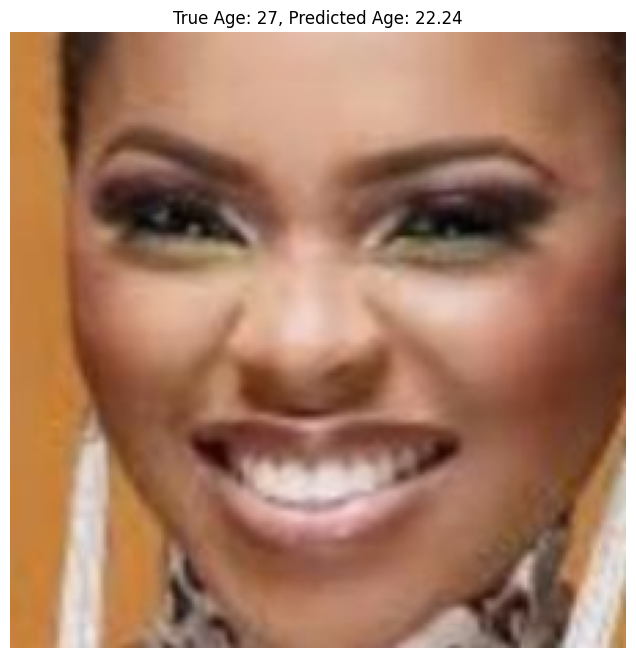

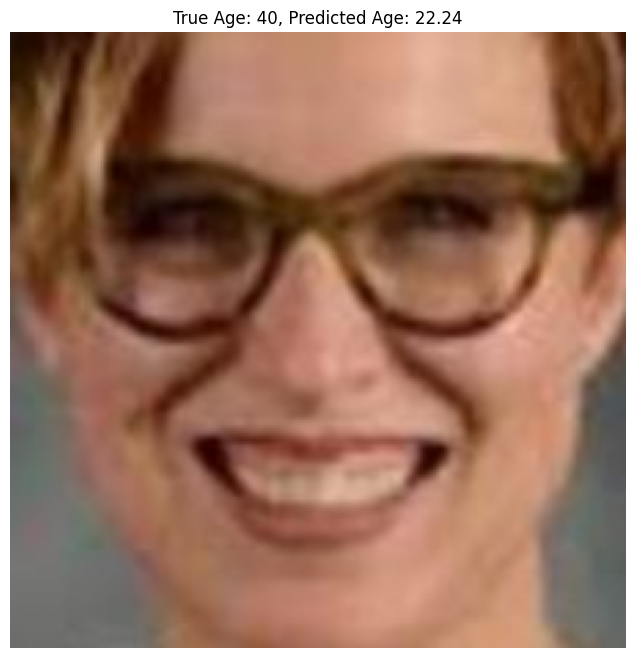

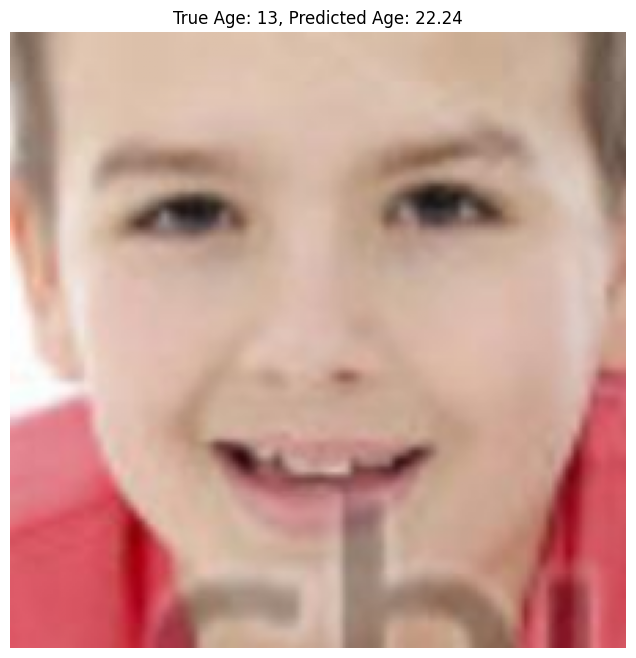

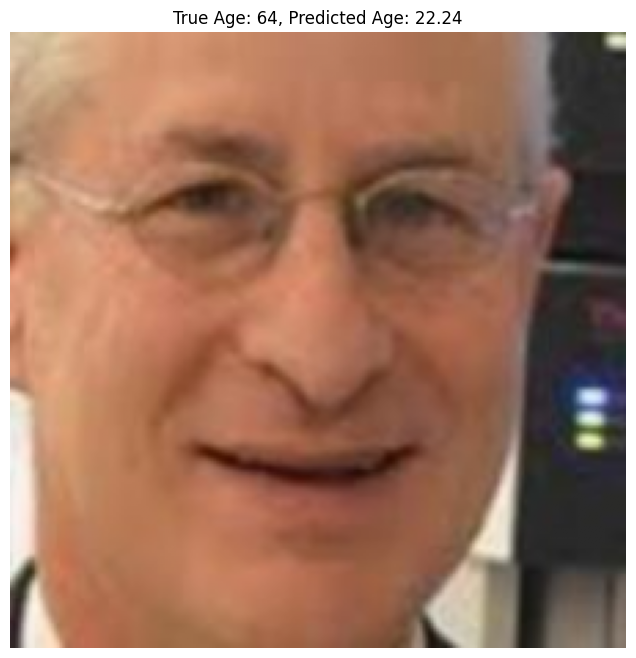

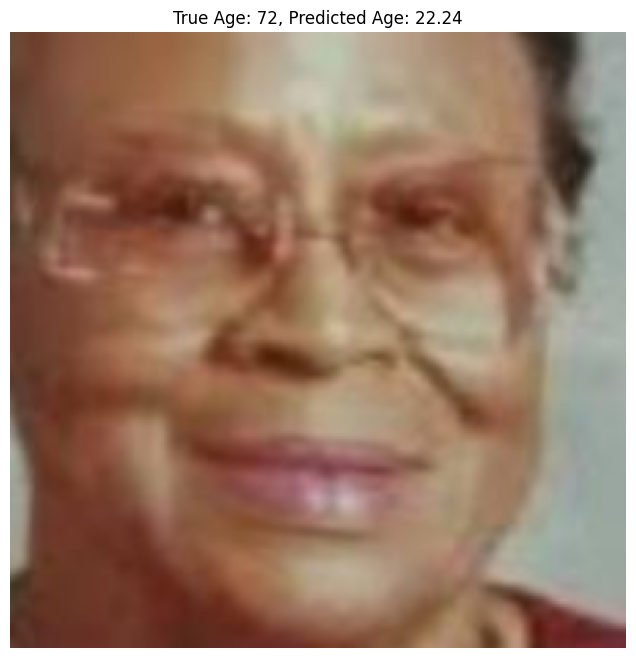

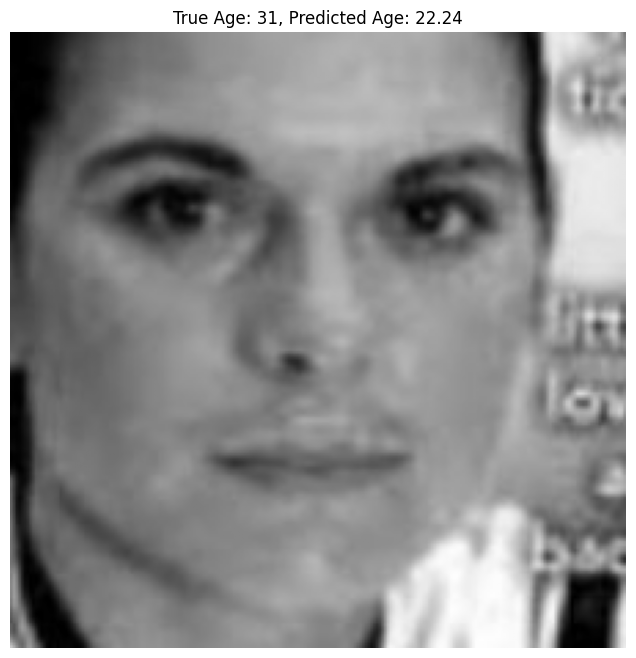

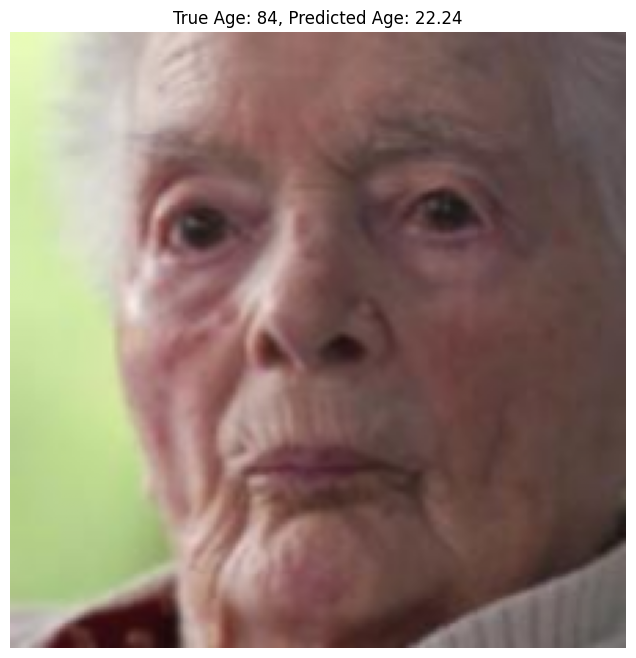

In [ ]:
# Afficher les images avec les prédictions d'âge comme titre
num_images_to_display = 10  # Vous pouvez ajuster le nombre d'images à afficher

for i in range(num_images_to_display):
    plt.figure(figsize=(8, 8))
    plt.imshow(X_test[i])
    true_age = y_test[i]
    predicted_age = predictions[0,0]
    plt.title(f'True Age: {true_age}, Predicted Age: {predicted_age:.2f}')
    plt.axis('off')
    plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calcul des métriques
mae = mean_absolute_error(y_test, predictions.flatten())
mse = mean_squared_error(y_test, predictions.flatten())
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions.flatten())

# Affichage des résultats
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R^2: {r2:.2f}')

MAE: 9.81
MSE: 174.54
RMSE: 13.21
R^2: 0.75


In [ ]:
tolerance = 10  # La fourchette acceptable autour de l'âge réel

# Calculer la précision
correct_predictions = np.sum(np.abs(y_test - predictions.flatten()) <= tolerance)
total_predictions = len(y_test)
accuracy = correct_predictions / total_predictions

# Afficher la précision
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 59.84%
